In [14]:
import gamspy as gp
import gamspy.math as gpm
from gamspy import Sum, Card, Container, Options, Problem, Sense


import sys
import numpy as np
import pandas as pd
import math
import itertools

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import contextily as ctx

#options = Options(equation_listing_limit=0)
#m = Container(options=options,debugging_level='keep')

In [15]:
options = Options(equation_listing_limit=0)
m = Container(options=options,debugging_level='keep')

In [16]:
#drone = pd.read_csv("/home/samjenkins2001/CS524/Project/Optimize/drone.csv")
drone = pd.read_csv("drone.csv")
#loc = pd.read_csv("/home/samjenkins2001/CS524/Project/Optimize/location.csv")
loc = pd.read_csv("location.csv")

drone_df = pd.DataFrame(drone)
loc_df = pd.DataFrame(loc)

In [17]:
locations = list(loc_df["Location"])
models = list(drone_df["Drone Models"])
loc_df.index = locations
drone_df.index = models
loc_df = loc_df.drop(columns = "Location")
drone_df = drone_df.drop(columns = "Drone Models")
display(loc_df)
display(drone_df)

,Latitude,Longitude,Payload,Demand
Camp Randall,43.070227,-89.412687,5.0000,5 Footballs
Sam's Apartment,43.075462,-89.393407,2.6250,History of Optimization book
3006 Sunrise Ct,43.108656,-89.473928,5.0000,Bird Food
Kohl Center,43.069709,-89.396907,4.6875,5 New Basketball Jerseys
Computer Sciences Building,43.071286,-89.406561,4.9360,8 NVIDIA Jetsons
Noland Hall,43.071678,-89.404489,1.5000,4 cups of Pepper Seeds
Lake Mendota,43.107811,-89.419515,4.0000,Fishing Rod
The Kollege Klub,43.075951,-89.397279,3.7500,Bottle of NA Vodka
Tenney Park,43.092186,-89.367120,2.2000,Drinking Fountain Filter
The Bakke,43.076852,-89.420159,3.4500,5 BUCKS Pre Workout


,Carrying Capacity,Fly in Rain,Speed,Radius,Charging Current
MK30,5,1,80.47,32.1,840
MK27,5,0,80.47,16.1,560


In [18]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    
    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return R * c

# Define depot and charging station
depot = {"DWI 4": (43.103263, -89.323598)}
sellery_location = [43.075182, -89.400503]

# Consumer locations with payload weights
locations = {
    "Camp Randall": (43.070227, -89.412687, 5.0),
    "Sam's Apartment": (43.075462, -89.393407, 2.6250),
    "3006 Sunrise Ct": (43.108656, -89.473928, 5.0000),
    "Kohl Center": (43.069709, -89.396907, 4.6875),
    "Computer Sciences Building": (43.071286, -89.406561, 4.936),
    "Noland Hall": (43.071678, -89.404489, 1.5000),
    "Lake Mendota": (43.107811, -89.419515, 4.0000),
    "The Kollege Klub": (43.075951, -89.397279, 3.75),
    "Tenney Park": (43.092186, -89.367120, 2.2000),
    "The Bakke": (43.076852, -89.420159, 3.4500),
    "The Nick": (43.070881, -89.399039, 4.16),
    "Governer's Mansion": (43.113096, -89.370588, 0.7000),
    "Wisconsin State Capital": (43.076583, -89.384819, 5.0000),
    "Henry Vilas Zoo": (43.060791, -89.410046, 3.0000),
    "The Edgewater": (43.079474, -89.389944, 3.4000),
    "Nandini's Apartment": (43.069867, -89.394065, 2.6250),
    "Sellery": (43.075182, -89.400503, 0),
    "DWI 4": (43.103263, -89.323598, 0)
}

# Max initial ranges
initial_range_mk27 = 16.1
initial_range_mk30 = 32.1


In [19]:
def calculate_distance_matrix(locations):
    location_names = list(locations.keys())
    distance_matrix = pd.DataFrame(index=location_names, columns=location_names, dtype=float)
    
    # Fill the DataFrame with distances
    for loc1, loc2 in itertools.combinations(location_names, 2):
        lat1, lon1 = locations[loc1][:2]
        lat2, lon2 = locations[loc2][:2]
        distance = haversine(lat1, lon1, lat2, lon2)
        
        # Assign distances symmetrically
        distance_matrix.loc[loc1, loc2] = distance
        distance_matrix.loc[loc2, loc1] = distance
        
    # Fill diagonal with zeros (distance from a location to itself)
    distance_matrix.fillna(0, inplace=True)
    
    return distance_matrix

distance_matrix = calculate_distance_matrix(locations)
display(distance_matrix)

,Camp Randall,Sam's Apartment,3006 Sunrise Ct,Kohl Center,Computer Sciences Building,Noland Hall,Lake Mendota,The Kollege Klub,Tenney Park,The Bakke,The Nick,Governer's Mansion,Wisconsin State Capital,Henry Vilas Zoo,The Edgewater,Nandini's Apartment,Sellery,DWI 4
Camp Randall,0.000000,1.670730,6.556717,1.283105,0.511353,0.685181,4.215772,1.404078,4.433676,0.954476,1.111001,5.865889,2.371363,1.070945,2.114153,1.513196,1.132698,8.113906
Sam's Apartment,1.670730,0.000000,7.508253,0.700032,1.164985,0.993626,4.175304,0.319160,2.831189,2.178340,0.684650,4.576557,0.708586,2.118531,0.527378,0.624427,0.577199,6.456905
3006 Sunrise Ct,6.556717,7.508253,0.000000,7.607455,6.869697,6.978635,4.418215,7.208503,8.862993,5.618606,7.390887,8.403234,8.066826,7.432470,7.552009,7.788551,7.028655,12.218878
Kohl Center,1.283105,0.700032,7.607455,0.000000,0.803556,0.653639,4.617416,0.694736,3.478365,2.048878,0.216738,5.276588,1.244301,1.456918,1.224281,0.231524,0.675037,7.025834
Computer Sciences Building,0.511353,1.164985,6.869697,0.803556,0.000000,0.173857,4.195409,0.915145,3.957428,1.266079,0.612659,5.490554,1.861625,1.200840,1.628062,1.027232,0.655595,7.617916
Noland Hall,0.685181,0.993626,6.978635,0.653639,0.173857,0.000000,4.198998,0.754135,3.796150,1.396776,0.451478,5.365458,1.688219,1.292008,1.465313,0.870349,0.506590,7.448851
Lake Mendota,4.215772,4.175304,4.418215,4.617416,4.195409,4.198998,0.000000,3.976262,4.595092,3.442881,4.430290,4.014962,4.471569,5.284634,3.961538,4.698150,3.942971,7.803234
The Kollege Klub,1.404078,0.319160,7.208503,0.694736,0.915145,0.754135,3.976262,0.000000,3.042661,1.861049,0.581601,4.664400,1.014461,1.979191,0.713005,0.725134,0.275470,6.709828
Tenney Park,4.433676,2.831189,8.862993,3.478365,3.957428,3.796150,4.595092,3.042661,0.000000,4.632542,3.511723,2.342071,2.253025,4.933824,2.330995,3.308778,3.305303,3.742207
The Bakke,0.954476,2.178340,5.618606,2.048878,1.266079,1.396776,3.442881,1.861049,4.632542,0.000000,1.839474,5.695863,2.870513,1.965782,2.471299,2.257332,1.607266,8.373013


In [20]:
# Route payload data
route_payloads = {
    ("DWI 4", "Sam's Apartment", "Noland Hall", "DWI 4"): [4.125, 1.50],
    ("DWI 4", "Sam's Apartment", "Tenney Park", "DWI 4"): [4.825, 2.20],
    ("DWI 4", "Sam's Apartment", "Governer's Mansion", "DWI 4"): [3.325, 0.700],
    ("DWI 4", "Noland Hall", "Tenney Park", "DWI 4"): [3.7, 2.20],
    ("DWI 4", "Noland Hall", "The Bakke", "DWI 4"): [4.95, 3.450],
    ("DWI 4", "Noland Hall", "Governer's Mansion", "DWI 4"): [2.2, 0.700],
    ("DWI 4", "Noland Hall", "Henry Vilas Zoo", "DWI 4"): [4.5, 3.0],
    ('DWI 4', 'Noland Hall', 'The Edgewater', 'DWI 4'): [4.90, 3.40],
    ("DWI 4", "Noland Hall", "Nandini's Apartment", "DWI 4"): [4.125, 2.625],
    ('DWI 4', 'Lake Mendota', "Governer's Mansion", 'DWI 4'): [4.7, 0.700],
    ('DWI 4', 'The Kollege Klub', "Governer's Mansion", 'DWI 4'): [4.45, 0.700],
    ('DWI 4', 'Tenney Park', "Governer's Mansion", 'DWI 4'): [2.90, 0.700],
    ('DWI 4', 'Tenney Park', "Nandini's Apartment", 'DWI 4'): [4.825, 2.625],
    ('DWI 4', 'The Bakke', "Governer's Mansion", 'DWI 4'): [4.15, 0.700],
    ('DWI 4', 'The Nick', "Governer's Mansion", 'DWI 4'): [4.86, 0.700],
    ('DWI 4', "Governer's Mansion", 'Henry Vilas Zoo', 'DWI 4'): [3.7, 3.00],
    ('DWI 4', "Governer's Mansion", 'The Edgewater', 'DWI 4'): [4.1, 3.400],
    ('DWI 4', "Governer's Mansion", "Nandini's Apartment", 'DWI 4'): [3.325, 2.625],
    ('DWI 4', "Sam's Apartment", 'Noland Hall', "Governer's Mansion", 'DWI 4'): [4.825, 2.2, 0.700],
    ('DWI 4', 'Noland Hall', 'Tenney Park', "Governer's Mansion", 'DWI 4'): [4.4, 2.9, 0.700],
    ('DWI 4', 'Noland Hall', "Governer's Mansion", "Nandini's Apartment", 'DWI 4'): [4.825, 3.325, 2.625]
}
# Assuming the locations and route_payloads dictionaries are already defined as you provided

# Assuming 'locations' and 'route_payloads' are already defined
depot_name = "DWI 4"
location_indices = {name: i for i, name in enumerate(locations.keys())}

# Initialize the payload matrix as a DataFrame
location_names = list(locations.keys())
payload_matrix = pd.DataFrame(np.zeros((len(location_names), len(location_names))), index=location_names, columns=location_names)

# Step 1: Populate direct payloads from the depot to all locations
for loc, payload in locations.items():
    if loc != depot_name:  # Exclude the depot itself
        idx_depot = location_indices[depot_name]
        idx_loc = location_indices[loc]
        
        # Use the third value (payload) for depot deliveries
        payload_matrix.loc[depot_name, loc] = payload[2]  # The third value in the tuple

# Step 2: Add payloads for non-depot transitions
for route, payloads in route_payloads.items():
    if depot_name in route[1:-1]:  # Skip transitions involving the depot as an intermediate location
        continue

    for i in range(len(route) - 1):
        loc1, loc2 = route[i], route[i + 1]

        # Only consider non-depot to non-depot transitions
        if loc1 != depot_name and loc2 != depot_name:
            idx1 = location_indices[loc1]
            idx2 = location_indices[loc2]
            payload = payloads[i]

            # Update the payload matrix for this transition
            payload_matrix.loc[loc1, loc2] = max(payload_matrix.loc[loc1, loc2], payload)

# Display the resulting matrix
display(payload_matrix)

,Camp Randall,Sam's Apartment,3006 Sunrise Ct,Kohl Center,Computer Sciences Building,Noland Hall,Lake Mendota,The Kollege Klub,Tenney Park,The Bakke,The Nick,Governer's Mansion,Wisconsin State Capital,Henry Vilas Zoo,The Edgewater,Nandini's Apartment,Sellery,DWI 4
Camp Randall,0.0,0.000,0.0,0.0000,0.000,0.0,0.0,0.00,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0.000,0.0,0.0
Sam's Apartment,0.0,0.000,0.0,0.0000,0.000,2.2,0.0,0.00,2.2,0.00,0.00,0.700,0.0,0.0,0.0,0.000,0.0,0.0
3006 Sunrise Ct,0.0,0.000,0.0,0.0000,0.000,0.0,0.0,0.00,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0.000,0.0,0.0
Kohl Center,0.0,0.000,0.0,0.0000,0.000,0.0,0.0,0.00,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0.000,0.0,0.0
Computer Sciences Building,0.0,0.000,0.0,0.0000,0.000,0.0,0.0,0.00,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0.000,0.0,0.0
Noland Hall,0.0,0.000,0.0,0.0000,0.000,0.0,0.0,0.00,2.9,3.45,0.00,3.325,0.0,3.0,3.4,2.625,0.0,0.0
Lake Mendota,0.0,0.000,0.0,0.0000,0.000,0.0,0.0,0.00,0.0,0.00,0.00,0.700,0.0,0.0,0.0,0.000,0.0,0.0
The Kollege Klub,0.0,0.000,0.0,0.0000,0.000,0.0,0.0,0.00,0.0,0.00,0.00,0.700,0.0,0.0,0.0,0.000,0.0,0.0
Tenney Park,0.0,0.000,0.0,0.0000,0.000,0.0,0.0,0.00,0.0,0.00,0.00,0.700,0.0,0.0,0.0,2.625,0.0,0.0
The Bakke,0.0,0.000,0.0,0.0000,0.000,0.0,0.0,0.00,0.0,0.00,0.00,0.700,0.0,0.0,0.0,0.000,0.0,0.0


In [21]:
def get_possible_routes():
    possible_routes = []
    unique_routes_set = set()  # Track unique routes by their items

    consumers = list(locations.keys())[:-2]

    # Generate all subsets of consumers
    for r in range(1, len(consumers) + 1):
        for subset in itertools.combinations(consumers, r):
            total_payload = sum(locations[consumer][2] for consumer in subset)

            # Skip if total payload exceeds 5 lbs
            if total_payload > 5:
                continue

            # Create a sorted tuple of consumers for route uniqueness
            sorted_route = tuple(sorted(subset))
            if sorted_route in unique_routes_set:
                continue
            unique_routes_set.add(sorted_route)

            # Distance calculation: Depot -> Consumers -> Depot (checking if recharge is needed)
            total_distance = 0
            start_lat, start_lon = depot["DWI 4"]
            route_with_recharge = ["DWI 4"]  # Start with DWI 4
            for consumer in subset:
                consumer_lat, consumer_lon = locations[consumer][:2]
                total_distance += haversine(start_lat, start_lon, consumer_lat, consumer_lon)
                start_lat, start_lon = consumer_lat, consumer_lon
                route_with_recharge.append(consumer)  # Add consumer name, not coordinates
            # Check if the total distance exceeds the range, and if so, add Sellery for recharge
            adjusted_range_mk30 = initial_range_mk30 * (1 - total_payload / 100)
            adjusted_range_mk27 = initial_range_mk27 * (1 - total_payload / 100)

            if total_distance > adjusted_range_mk30:  # Check for MK30 range
                # Add Sellery as a recharge stop
                route_with_recharge.append("Sellery")  # Add Sellery name as a stop
                total_distance += haversine(start_lat, start_lon, sellery_location[0], sellery_location[1])
                start_lat, start_lon = sellery_location  # Update to Sellery location
                # Recharge at Sellery (reset distance after recharge)
                total_distance = 0  # Reset total distance after recharge
            # Return to depot after all consumers and possible recharge
            total_distance += haversine(start_lat, start_lon, depot["DWI 4"][0], depot["DWI 4"][1])
            route_with_recharge.append("DWI 4")
            # Determine feasibility based on the adjusted range
            mk30_feasible = total_distance <= adjusted_range_mk30
            mk27_feasible = total_distance <= adjusted_range_mk27

            drone_type = None
            if mk30_feasible and mk27_feasible:
                drone_type = "Both"
            elif mk30_feasible:
                drone_type = "MK30"
            elif mk27_feasible:
                drone_type = "MK27"

            if drone_type:
                possible_routes.append({
                    "Route": tuple(route_with_recharge),  # Store as a tuple
                    "Payload (lbs)": total_payload,
                    "Total Distance (km)": total_distance,
                    "Drone Type": drone_type
                })

    return possible_routes
# Get all possible routes
routes = get_possible_routes()
# Convert to DataFrame and display
routes_df = pd.DataFrame(routes)
routes_df.to_csv('routes.csv', index=False)
display(routes_df)

,Route,Payload (lbs),Total Distance (km),Drone Type
0,"(DWI 4, Camp Randall, DWI 4)",5.0000,16.227811,MK30
1,"(DWI 4, Sam's Apartment, DWI 4)",2.6250,12.913810,Both
2,"(DWI 4, 3006 Sunrise Ct, DWI 4)",5.0000,24.437757,MK30
3,"(DWI 4, Kohl Center, DWI 4)",4.6875,14.051669,Both
4,"(DWI 4, Computer Sciences Building, DWI 4)",4.9360,15.235831,Both
5,"(DWI 4, Noland Hall, DWI 4)",1.5000,14.897702,Both
6,"(DWI 4, Lake Mendota, DWI 4)",4.0000,15.606467,MK30
7,"(DWI 4, The Kollege Klub, DWI 4)",3.7500,13.419655,Both
8,"(DWI 4, Tenney Park, DWI 4)",2.2000,7.484415,Both
9,"(DWI 4, The Bakke, DWI 4)",3.4500,16.746026,MK30


In [22]:
# Mapping location names to integers
location_to_int = {
    "DWI 4": 1,
    "Camp Randall": 2,
    "Sam's Apartment": 3,
    "3006 Sunrise Ct": 4,
    "Kohl Center": 5,
    "Computer Sciences Building": 6,
    "Noland Hall": 7,
    "Lake Mendota": 8,
    "The Kollege Klub": 9,
    "Tenney Park": 10,
    "The Bakke": 11,
    "The Nick": 12,
    "Governer's Mansion": 13,
    "Wisconsin State Capital": 14,
    "Henry Vilas Zoo": 15,
    "The Edgewater": 16,
    "Nandini's Apartment": 17,
    "Sellery": 18,
}

# Generate tuples of customers (as integers) and their corresponding routes
def generate_customer_route_tuples(routes_df):
    customer_route_tuples = []

    # Iterate over each row in the DataFrame
    for route_index, route in routes_df.iterrows():
        route_customers = route['Route']  # Get the list of customer names for this route
        
        # Initialize a flag to check if DWI 4 (18) has been added
        dwi4_added = False

        for customer in route_customers:
            customer_int = location_to_int[customer]  # Map customer name to integer
            
            # Only add DWI 4 once for the route
            if customer_int == 1 and not dwi4_added:
                customer_route_tuples.append((f'r{route_index + 1}', str(customer_int)))  # Reverse tuple order
                dwi4_added = True
            elif customer_int != 1:
                customer_route_tuples.append((f'r{route_index + 1}', str(customer_int)))  # Reverse tuple order

    return customer_route_tuples




# Generate the customer-route tuples
location_route_tuples = generate_customer_route_tuples(routes_df)
customer_route_tuples = [tuple for tuple in location_route_tuples if tuple[1] != '1']
distance_list = routes_df["Total Distance (km)"].tolist()
payload_list = loc_df["Payload"].tolist()

In [ ]:
#CLEAN COPY



#STEP 1: DEFINE BASIC SETS
#We have 2 drones - one MK30 (k=1) and one MK27 (k=2)
k = m.addSet('k', records=[i+1 for i in range(2)], 
             description='Available drones (1=MK30, 2=MK27)')

#Define locations: 18 total locations including delivery points, depot, and charging stations
i = m.addSet('i', records=[i+1 for i in range(18)], 
             description='All locations in Madison area')

z = m.addAlias('z', i)  # Alias needed for distance calculations

#Define 16 customers who need deliveries (excluding depot and charging station)
s = m.addSet('s', records=[i+2 for i in range(16)], 
             description='Customer delivery locations')

#Define 37 possible delivery routes
j = m.addSet('j', records=['r'+str(i+1) for i in range(37)], 
             description='All possible delivery routes')

#STEP 2: DEFINE DRONE CAPABILITIES
#Set drone ranges (how far they can fly on one charge)
mk30_range = m.addParameter("mk30_range", records=32.1)
mk27_range = m.addParameter("mk27_range", records=16.1)

#STEP 3: ROUTE-LOCATION RELATIONSHIPS
#L shows which locations are in each route
L = m.addSet('L', [j, i], records=location_route_tuples)

#C shows which customers are served by each route
C = m.addSet('C', [j, s], records=customer_route_tuples)

#STEP 4: DECISION VARIABLES
x = m.addVariable('x', 'binary', domain=[j, k], description = "x[j,k] = 1 if drone k takes route j")
y = m.addVariable('y', 'binary', domain=[i, k], description = "y[i,k] = 1 if drone k visits location i")
b = m.addVariable('b', 'positive', domain=[j, k], description = "Battery level of drone k after completing route j")
delta = m.addVariable('delta', 'positive', domain=[k], description = " Amount of charging needed for drone k")

#STEP 5: ROUTING CONSTRAINTS

#Ensure routes and locations match
location_route_link_1 = m.addEquation('location_route_link_1', domain=[i, k, j])
location_route_link_1[i, k, j] = y[i, k] >= x[j, k] * L[j, i]

location_route_link_2 = m.addEquation('location_route_link_2', domain=[i, k])
location_route_link_2[i, k] = y[i, k] <= Sum(j, L[j, i] * x[j, k])

# Every customer must be served exactly once
cover = m.addEquation('cover', domain=[s])
cover[s] = Sum((j, k), C[j, s] * x[j, k]) == 1

# Each route can be assigned to at most one drone
route_assignment = m.addEquation('route_assignment', domain=[j])
route_assignment[j] = Sum(k, x[j, k]) <= 1

#STEP 6: DISTANCE AND BATTERY CONSTRAINTS
# Record the distance for each route
route_distance_records = [{
    'j': f'r{i+1}',
    'value': distance_list[i]
} for i in range(len(distance_list))]

route_distance = m.addParameter("route_distance", domain=[j], 
                              records=route_distance_records)

# Battery constraints

# All drones start fully charged (intial charge)
battery_init = m.addEquation('battery_init', domain=[k])
battery_init[k] = b["r1", k] == 100 

#Battery tracking: For each route and drone
#Starts at 100%
#Subtracts battery used based on route distance
#Adds any charging (delta)
#The '100' multiplier converts from percentage to actual battery units
battery_tracking1 = m.addEquation('battery_tracking1', domain=[j, k])
battery_tracking1[j, k] = (
    b[j, k] <= 100 - (
        x[j, '1'] * route_distance[j] / mk30_range +  # MK30 battery drain
        x[j, '2'] * route_distance[j] / mk27_range    # MK27 battery drain
    ) * 100 + delta[k]
)

# Battery can't go negative
positive_battery = m.addEquation('positive_battery', domain=[j, k])
positive_battery[j, k] = b[j, k] >= 0 

# Can't charge more than 100%
recharging = m.addEquation('recharging', domain=[k])
recharging[k] = delta[k] <= 100 

# MK27 has shorter range than MK30
mk27_range_limit = m.addEquation('mk27_range_limit', domain=[j])
mk27_range_limit[j] = x[j, "2"] * (route_distance[j] / mk27_range) <= 1

#STEP 7: PAYLOAD CONSTRAINTS
# Record payload weights for each route
route_payload_records = [{
    'j': f'r{i+1}',
    'value': routes_df['Payload (lbs)'].iloc[i]
} for i in range(len(payload_list))]

route_payload = m.addParameter("route_payload", domain=[j], 
                             records=route_payload_records)

# Each drone has 5 lb payload limit
payload_capacity = m.addEquation('payload_capacity', domain=[j, k])
payload_capacity[j, k] = x[j, k] * route_payload[j] <= 5

#STEP 8: OPERATIONAL CONSTRAINTS
#Each drone can handle between 5 and 7 routes
#I chose 7 because I was not getting infeasible here lol
max_routes_per_drone = m.addEquation('max_routes_per_drone', domain=[k])
max_routes_per_drone[k] = Sum(j, x[j, k]) <= 7

balance_workload = m.addEquation('balance_workload', domain=[k])
balance_workload[k] = Sum(j, x[j, k]) >= 5

#STEP 9: WEATHER CONSTRAINTS
# Mark routes with rain (every third route for this example)
rain_route_records = [{
    'j': f'r{i+1}',
    'value': 1 if i % 3 == 0 else 0
} for i in range(len(distance_list))]

rain_routes = m.addParameter("rain_routes", domain=[j], 
                           records=rain_route_records)

# MK27 (k=2) cannot fly in rain
rain_constraint = m.addEquation('rain_constraint', domain=[j])
rain_constraint[j] = x[j, '2'] * rain_routes[j] <= 0

#not sure if this is needed to be done
# Objective: Minimize routes + small penalty for charging -> objective=Sum([j, k], x[j, k]) + 0.01 * total_charging
#total_charging = Sum(k, delta[k])

setcover = m.addModel('setcover',
    equations=m.getEquations(),
    problem=Problem.MIP,
    sense=Sense.MIN,
    objective=Sum([j, k], x[j, k])
)

# Solve the model
setcover.solve(output=None, options=Options(absolute_optimality_gap=0.999))


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,13,1738,187,MIP,CPLEX,0.013


In [32]:

print(delta.records)

x_df = pd.DataFrame(x.records)
delta_df = pd.DataFrame(delta.records)

# Get active routes (where level > 0.5)
active_routes = x_df[x_df['level'] > 0.5]

print("\n1. All Active Routes:")
print(active_routes[['j', 'k', 'level']])

print("\n2. Charging Needed:")
print(delta_df[delta_df['level'] > 0])

print("\n3. Simple Summary:")
print(f"Total Routes: {len(active_routes)}")
print(f"Objective Value: {setcover.objective_value:.3f}")

   k  level  marginal  lower  upper  scale
0  1  100.0       0.0    0.0    inf    1.0
1  2  100.0       0.0    0.0    inf    1.0

1. All Active Routes:
      j  k  level
0    r1  1    1.0
3    r2  2    1.0
4    r3  1    1.0
6    r4  1    1.0
9    r5  2    1.0
12   r7  1    1.0
18  r10  1    1.0
21  r11  2    1.0
24  r13  1    1.0
26  r14  1    1.0
47  r24  2    1.0
53  r27  2    1.0
57  r29  2    1.0

2. Charging Needed:
   k  level  marginal  lower  upper  scale
0  1  100.0       0.0    0.0    inf    1.0
1  2  100.0       0.0    0.0    inf    1.0

3. Simple Summary:
Total Routes: 13
Objective Value: 13.000


In [26]:
print("\nModel Summary:")
print(f"Drones: {len(k.records)}")
print(f"Consumers: {len(s.records)}")
print(f"Routes: {len(j.records)}")



Model Summary:
Drones: 2
Consumers: 16
Routes: 37


In [27]:
x.records.to_csv('optimal.csv', index=False)
display(x.records)

,j,k,level,marginal,lower,upper,scale
0,r1,1,1.0,1.0,0.0,1.0,1.0
1,r1,2,0.0,1.0,0.0,1.0,1.0
2,r2,1,0.0,1.0,0.0,1.0,1.0
3,r2,2,1.0,1.0,0.0,1.0,1.0
4,r3,1,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...
69,r35,2,0.0,1.0,0.0,1.0,1.0
70,r36,1,0.0,1.0,0.0,1.0,1.0
71,r36,2,0.0,1.0,0.0,1.0,1.0
72,r37,1,0.0,1.0,0.0,1.0,1.0


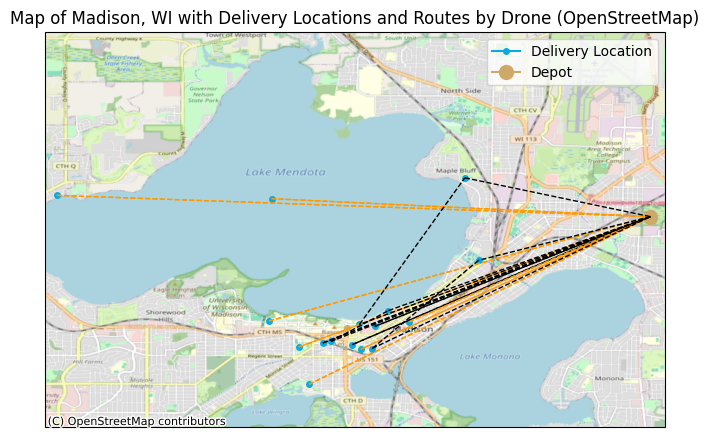

In [29]:
# Example: Coordinates for delivery and charging locations
latitudes = list(loc_df["Latitude"])
longitudes = list(loc_df["Longitude"])
coordinates = list(zip(latitudes, longitudes))

delivery_coords = coordinates[:-2]
charge_coords = coordinates[-2:]

# Extract the selected routes with their assigned drones
selected_routes = [(row["j"], row["k"]) for index, row in x.records.iterrows() if row["level"] == 1.0]

# Set up the map
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-89.477, -89.32, 43.05, 43.15], crs=ccrs.PlateCarree())
ctx.add_basemap(ax, crs=ccrs.PlateCarree(), source=ctx.providers.OpenStreetMap.Mapnik)

# Plot delivery locations
for coord in delivery_coords:
    latitude = coord[0]
    longitude = coord[1]
    ax.plot(
        longitude,
        latitude,
        marker="o",
        color="#08AAE3",
        markersize=4,
        transform=ccrs.PlateCarree(),
        label="Delivery Location" if coord == delivery_coords[0] else "",
    )

# Plot charge locations
for coord in charge_coords:
    latitude = coord[0]
    longitude = coord[1]
    ax.plot(
        longitude,
        latitude,
        marker="o",
        color="#CEA968",
        markersize=4 if coord == charge_coords[0] else 10,
        transform=ccrs.PlateCarree(),
        label="Depot" if coord == charge_coords[1] else None,
    )

depot_lat, depot_lon = charge_coords[1]  # Assuming the second charge location is the Depot

# Define colors for drones
drone_colors = {"1": "#FF9900", "2": "#000000"}

# Iterate over selected routes and plot
# Iterate over selected routes
for route, drone in selected_routes:
    # Extract customers assigned to the current route
    customers_in_route = [
        customer
        for assigned_route, customer in customer_route_tuples
        if assigned_route == route  # Match directly using the route
    ]

    # Reverse the mapping for easier lookup
    int_to_location = {v: k for k, v in location_to_int.items()}

    if customers_in_route:
        previous_customer_coords = locations["DWI 4"][:2]  # Start at DWI 4 (Depot)
        for customer_index in customers_in_route:

            # Validate customer_index
            if int(customer_index) not in int_to_location:
                print(f"Invalid customer_index: {customer_index}")
                continue

            # Get the location name and coordinates
            location_name = int_to_location[int(customer_index)]
            customer_coords = locations.get(location_name)
            if not customer_coords:
                print(f"Coordinates not found for location: {location_name}")
                continue  # Skip if location not found

            customer_lat, customer_lon = customer_coords[:2]

            # Plot line from previous location to current customer
            ax.plot(
                [previous_customer_coords[1], customer_lon],
                [previous_customer_coords[0], customer_lat],
                color=drone_colors[drone],
                linestyle="--",
                linewidth=1,
                transform=ccrs.PlateCarree(),
            )

            # Update the previous location
            previous_customer_coords = (customer_lat, customer_lon)

        # Return to Depot after last delivery
        depot_coords = locations["DWI 4"][:2]
        ax.plot(
            [previous_customer_coords[1], depot_coords[1]],
            [previous_customer_coords[0], depot_coords[0]],
            color=drone_colors[drone],
            linestyle="--",
            linewidth=1,
            transform=ccrs.PlateCarree(),
        )


# Add the legend
plt.legend()

# Add a title
plt.title("Map of Madison, WI with Delivery Locations and Routes by Drone (OpenStreetMap)")

# Show the map
plt.show()

